In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 55)

## Data loading

In [2]:
def load_data():
    df = pd.read_csv("540_data.csv")
    convert_dict = {
                    "pH": float,
                    'Catalyst Loading (mg/cm2)': float,
                    "Presence of atoms (other than TMs)" : float,
                    "Average d electrons": float,
                    'Overpotential (mV)': float
                }

    df = df.astype(convert_dict)
    df = df.drop(["Compound"], axis=1)
    return df

## Pre *processing*

In [3]:
atomicMassMap = {
    'cobalt': 64,
    'nickel': 59,
    'iron': 56,
    "molybdenum": 96,
    'manganese': 55,
    "copper": 64,
    "zinc": 65,
    "chromium": 52,
    "vanadium": 51,
    "tungsten": 184,
    "titanium": 48,
    "iridium": 192
}

In [4]:
def mulitply_number_of_atoms_to_its_mass_number():
    for col in df.columns:
        if col.lower().split(' ')[0] in atomicMassMap:
            df[col] = df[col].values.astype(float) * atomicMassMap[col.lower().split(' ')[0]]

In [5]:
def find_and_handle_missing_values(model_name):
    print("Missing values columns:", list(df.columns[df.isnull().any()]))

    if model_name != "catboost":
        df['Catalyst Loading (mg/cm2)'].fillna(df['Catalyst Loading (mg/cm2)'].mean() , inplace = True)
        df["Average d electrons"].fillna(df['Average d electrons'].mean() , inplace = True)

## Data analysis

In [6]:
def get_number_of_features():

    training_features = df.columns[0:-1]
    continuous_features = []
    categorical_features = []

    for col in training_features:
        if df[col].dtypes == float:
            continuous_features.append(col)
        else:
            categorical_features.append(col)

    total_number_of_features = len(training_features)
    print("Total number of training features: ", total_number_of_features) 

    print("Number of continuous variables:", len(continuous_features))
    print("Continuous features:", continuous_features)

    print("Number of categorical variables: ", len(categorical_features))
    print("Categorical features:", categorical_features)

    return training_features, continuous_features, categorical_features

In [7]:
def plot_correlation(data):
    plt.subplots(figsize=(16,16))
    dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
    plt.show()

## Train test split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
def split_data_into_train_test():
    x = df.values[:, 0:-1]
    y = df.values[:, -1]

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state = 0, shuffle=True
    )
    return x_train, x_test, y_train, y_test

In [10]:
def train_and_test_split():
    x_train, x_test, y_train, y_test = split_data_into_train_test()

    print(x_train[0])
    print(y_train[0])
    print(type(x_train), type(y_train))
    print("number of train data: ", len(y_train))
    print("number of test data: ", len(y_test))

    return x_train, y_train, x_test, y_test

## Error **analysis**

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error 

def getMetrics(x_test, y_test, model):
    y_pred = model.predict(x_test)
    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('RMSE = ', mean_squared_error(y_test, y_pred) ** 0.5)
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print( "MAPE = ", mean_absolute_percentage_error(y_test, y_pred))

In [12]:
def get_feature_importance_from_trained_model(model):

    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    return feature_importance, sorted_idx

In [13]:
def plot_feature_importance(feature_importance, sorted_idx):
    fig = plt.figure(figsize=(20, 10))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), training_features[sorted_idx])
    plt.title('Feature Importance')

## Encoding cat_features

In [14]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_features(df):
    types_of_compounds = list(df['Compound Class'].value_counts().keys())
    types_of_substrates = list(df['Substrates'].value_counts().keys())
    
    labelencoder = LabelEncoder()
    df['Compound Class']= labelencoder.fit_transform(df['Compound Class'])
    df['Substrates']= labelencoder.fit_transform(df['Substrates'])

    compound_encoding_labels = {}
    a1 = list(df['Compound Class'].value_counts().keys())
    for i in range(len(a1)):
        compound_encoding_labels[types_of_compounds[i]] = a1[i]

    substrate_encoding_labels = {}
    a2 = list(df['Substrates'].value_counts().keys())
    for i in range(len(a2)):
        substrate_encoding_labels[types_of_substrates[i]] = a2[i]

    return compound_encoding_labels, substrate_encoding_labels

## Random forest

In [15]:
df = load_data()

print("Shape of data:", df.shape)

mulitply_number_of_atoms_to_its_mass_number()

compound_encoding_labels, substrate_encoding_labels = encode_categorical_features(df)
print(compound_encoding_labels, substrate_encoding_labels)

training_features, continuous_features, categorical_features = get_number_of_features()

model_name = "random_forest"
find_and_handle_missing_values(model_name)

Shape of data: (305, 26)
{'Co': 0, 'Ni': 2, 'Fe': 1, 'Other TMs': 3} {'GC': 0, 'NF': 1, 'carbon_based': 3, 'TM_based': 2}
Total number of training features:  25
Number of continuous variables: 15
Continuous features: ['Presence of atoms (other than TMs)', 'Cobalt atoms', 'Nickel atoms', 'Iron atoms', 'Molybdenum atoms', 'Manganese atoms', 'Copper atoms', 'Zinc atoms', 'Chromium Atoms', 'Vanadium Atoms', 'Tungsten atoms', 'Titanium atoms', 'Average d electrons', 'pH', 'Catalyst Loading (mg/cm2)']
Number of categorical variables:  10
Categorical features: ['Compound Class', 'Composite (Y or N)', 'Presence of Carbon', 'Carbon Structures', 'N-doped Carbon Structure (0 or 1)', 'Doping (other than TMs)', 'Morphology Category', 'Grown on', 'Porous - 1, Non-Porous - 0', 'Substrates']
Missing values columns: ['Average d electrons', 'Catalyst Loading (mg/cm2)']


In [16]:
x_train, y_train, x_test, y_test = train_and_test_split()

[ 2.     0.     0.     0.     0.     0.     6.     0.     1.     0.
  0.     0.    59.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     3.5   14.     0.203]
415.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
number of train data:  244
number of test data:  61


In [17]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 0, max_features="sqrt")
rf.fit(x_train, y_train)

RandomForestRegressor(max_features='sqrt', random_state=0)

In [18]:
print("\nTest error:")
getMetrics(x_test, y_test, rf)


Test error:
MSE:  2683.173317828334
RMSE =  51.799356345695394
MAE:  42.60773614363779
MAPE =  0.1393612832270068


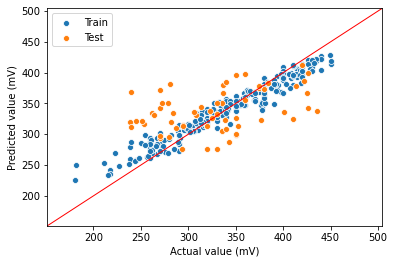

In [20]:
y_test_pred = rf.predict(x_test)
y_train_pred = rf.predict(x_train)

Y_max = max(y_train_pred.max(), y_test_pred.max()) + 75
Y_min = min(y_train_pred.min(), y_test_pred.min()) - 75

ax = sns.scatterplot(x=y_train, y=y_train_pred, label = "Train")
ax = sns.scatterplot(x=y_test, y=y_test_pred, label = "Test")
ax.set(ylim=(Y_min, Y_max))
ax.set(xlim=(Y_min, Y_max))
ax.set_xlabel("Actual value (mV)")
ax.set_ylabel("Predicted value (mV)")

X_ref = Y_ref = np.linspace(Y_min, Y_max, 100)
plt.plot(X_ref, Y_ref, color='red', linewidth=1)
plt.savefig("QQ_plot.png")
plt.show()

np.savetxt("y_test_pred.csv", y_test_pred)
np.savetxt("y_test.csv", y_test)
np.savetxt("y_train_pred.csv", y_train_pred)
np.savetxt("y_train.csv", y_train)

[0.03403733 0.03378621 0.03217721 0.01581431 0.03109742 0.01276209
 0.01572333 0.06496824 0.04693618 0.04787386 0.04570196 0.02313808
 0.06291949 0.07098606 0.08127053 0.01006846 0.01226747 0.00448984
 0.01170659 0.01318049 0.00482198 0.00163477 0.00114915 0.14067569
 0.04165128 0.13916197] [22 21 17 20 15 18 16  5 19  6  3 11  4  2  1  0 24 10  8  9 12  7 13 14
 25 23]


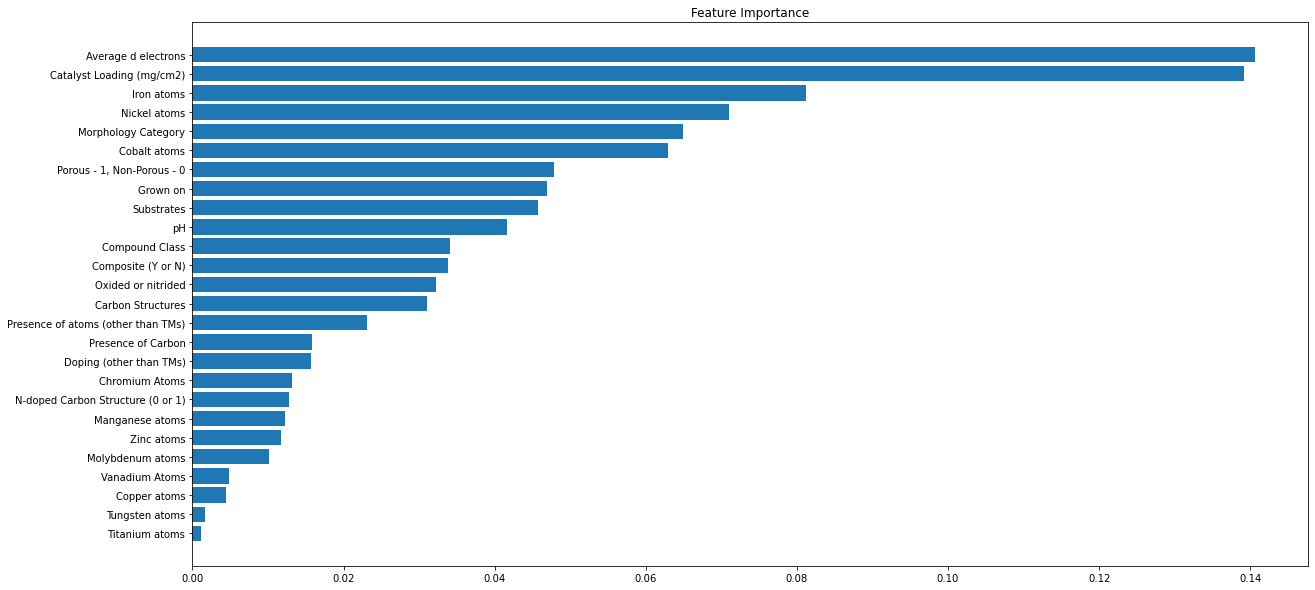

In [69]:
feature_importance, sorted_idx = get_feature_importance_from_trained_model(rf)
plot_feature_importance(feature_importance, sorted_idx)
print(feature_importance, sorted_idx)

## SVM

In [74]:
from sklearn import svm

clf = svm.SVR()
clf.fit(x_train, y_train)

SVR()

In [75]:
print("\nTest error:")
getMetrics(x_test, y_test, clf)


Test error:
MSE:  3174.74876550592
RMSE =  56.344908958182906
MAE:  46.450045851569854
MAPE =  0.14655297213038046


## Naive Bayes

In [76]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB()

In [77]:
print("\nTest error:")
getMetrics(x_test, y_test, gnb)


Test error:
MSE:  4565.7962962962965
RMSE =  67.57067630486095
MAE:  52.96296296296296
MAPE =  0.16659167796114852


## MLP

In [78]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(random_state=0)
mlp.fit(x_train, y_train)

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


MLPRegressor(random_state=0)

In [79]:
print("\nTest error:")
getMetrics(x_test, y_test, mlp)


Test error:
MSE:  7015.994481482457
RMSE =  83.76153342365728
MAE:  67.44443322034873
MAPE =  0.20555351582992712
